In [ ]:
# 📌 Installation des librairies manquantes
!pip install boto3

# 📌 Importation des librairies
import os
import boto3
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [ ]:
# 📌 Téléchargement du dataset ZIP depuis S3 si nécessaire
dataset_zip_s3 = "oily-dry-and-normal-skin-types-dataset.zip"  # Nom du fichier ZIP sur S3
dataset_local_zip = "/content/dataset_skin_types.zip"  # Où on va le stocker localement

if "COLAB_GPU" in os.environ:
    print("📥 Téléchargement du dataset depuis S3...")
    s3.download_file(bucket_name, dataset_zip_s3, dataset_local_zip)

    # 📌 Extraction du ZIP
    import zipfile
    with zipfile.ZipFile(dataset_local_zip, 'r') as zip_ref:
        zip_ref.extractall("/content/dataset_skin_types")  # Extraction
    print("✅ Dataset extrait !")

📥 Téléchargement du dataset depuis S3...
✅ Dataset extrait !


In [ ]:
# 📌 Détection de l'environnement et correction du chemin du dataset
if "COLAB_GPU" in os.environ:
    print("🔍 Détection : Environnement Google Colab")
    dataset_path = "/content/dataset_skin_types/Oily-Dry-Skin-Types"
else:
    print("🔍 Détection : Environnement Local (Mac / Docker)")
    dataset_path = "Oily-Dry-Skin-Types"  # ✅ Chemin générique pour Mac ET Docker

# 📌 Vérification du chemin après téléchargement/extraction
if os.path.exists(dataset_path):
    print(f"✅ Dataset trouvé : {dataset_path}")
else:
    print(f"❌ ERREUR : Le chemin {dataset_path} n'existe pas, vérifiez le chemin !")

🔍 Détection : Environnement Google Colab
✅ Dataset trouvé : /content/dataset_skin_types/Oily-Dry-Skin-Types


In [ ]:
# 📌 Paramètres généraux
batch_size = 32
img_size = (224, 224)

In [ ]:
# 📌 Chargement des datasets depuis le répertoire local (Colab ou Docker)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path + "/train",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical"
)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path + "/valid",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical"
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path + "/test",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical"
)

Found 2756 files belonging to 3 classes.
Found 262 files belonging to 3 classes.
Found 134 files belonging to 3 classes.


In [ ]:
# 📌 Vérification des datasets
print(f"✅ Train dataset : {train_ds}")
print(f"✅ Validation dataset : {valid_ds}")
print(f"✅ Test dataset : {test_ds}")

✅ Train dataset : <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>
✅ Validation dataset : <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>
✅ Test dataset : <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>


In [ ]:
# 📌 Définition des catégories
categories = ["dry", "normal", "oily"]

# 📌 Comptage des images par classe dans chaque dataset
def count_images_per_class(dataset):
    """Retourne le nombre d'images par classe dans un dataset TensorFlow"""
    class_counts = {class_name: 0 for class_name in categories}  # Initialisation
    for image, label in dataset.unbatch():
        class_counts[categories[np.argmax(label.numpy())]] += 1  # Incrémentation
    return class_counts

In [ ]:
# 📌 Calcul des statistiques détaillées
train_counts = count_images_per_class(train_ds)
valid_counts = count_images_per_class(valid_ds)
test_counts = count_images_per_class(test_ds)

In [ ]:
# 📌 Création d'un DataFrame détaillé
df_detailed_counts = pd.DataFrame({
    "Classe": categories,
    "Train": [train_counts[cat] for cat in categories],
    "Validation": [valid_counts[cat] for cat in categories],
    "Test": [test_counts[cat] for cat in categories]
})

# 📌 Affichage du tableau
print(df_detailed_counts)

   Classe  Train  Validation  Test
0     dry    652          71    35
1  normal   1104         111    59
2    oily   1000          80    40


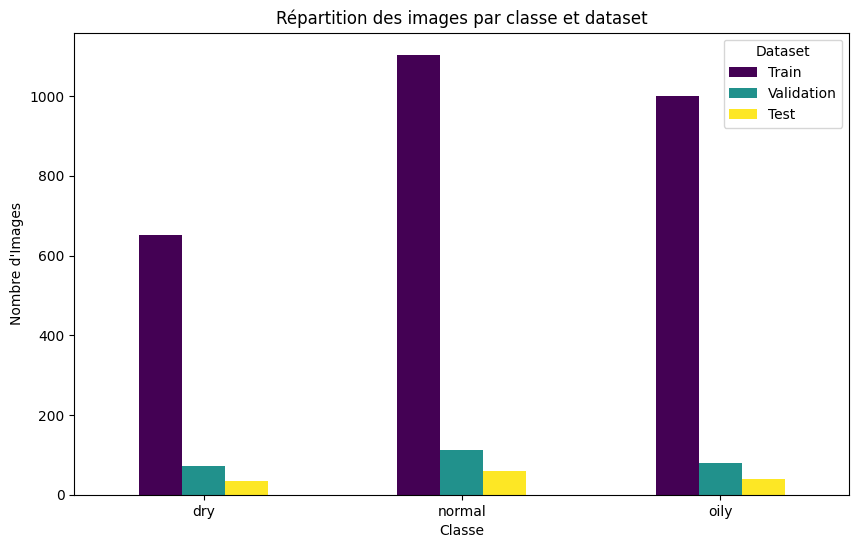

In [ ]:
# 📌 Visualisation de la distribution par dataset et classe
df_detailed_counts.set_index("Classe").plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.xlabel("Classe")
plt.ylabel("Nombre d'Images")
plt.title("Répartition des images par classe et dataset")
plt.xticks(rotation=0)
plt.legend(title="Dataset")
plt.show()

In [ ]:
def show_images(dataset, title, num_images=5):
    """ Affiche quelques images avec leurs labels """
    plt.figure(figsize=(15, 5))
    for images, labels in dataset.take(1):  # Prend un batch du dataset
        for i in range(num_images):
            plt.subplot(1, num_images, i+1)
            plt.imshow(images[i].numpy().astype("uint8"))  # Convertir en image affichable
            label_index = np.argmax(labels[i].numpy())  # Trouver l'index du label
            plt.title(f"Label: {categories[label_index]}")
            plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()

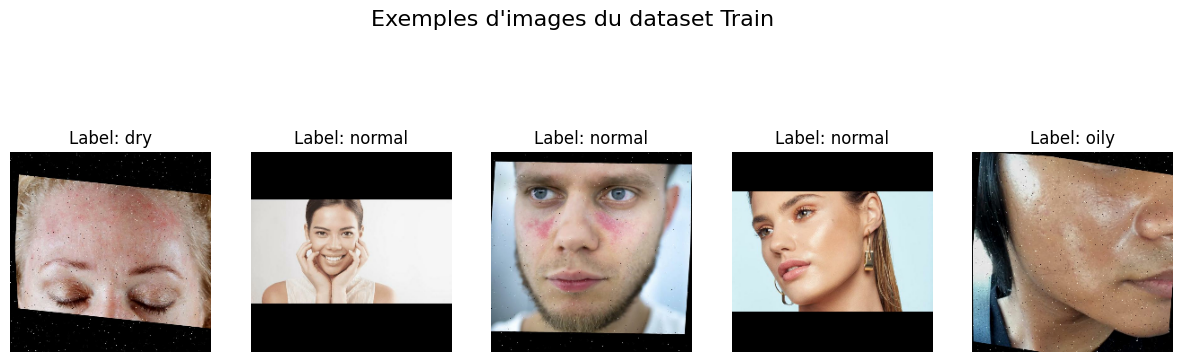

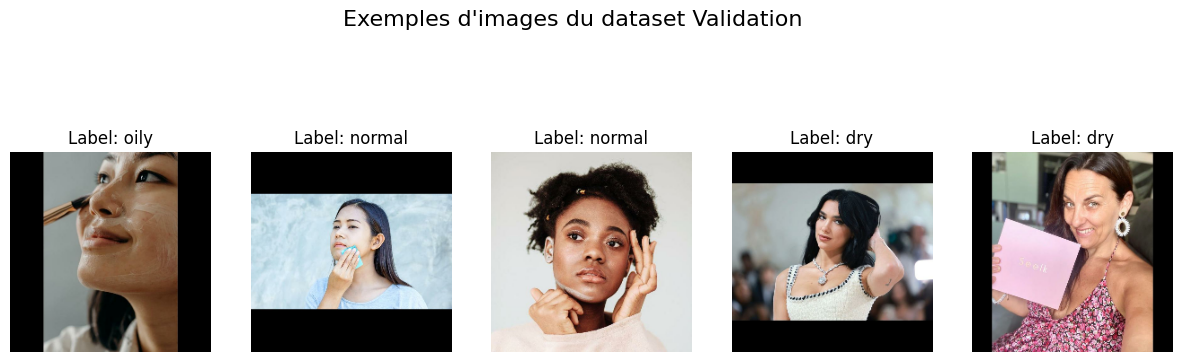

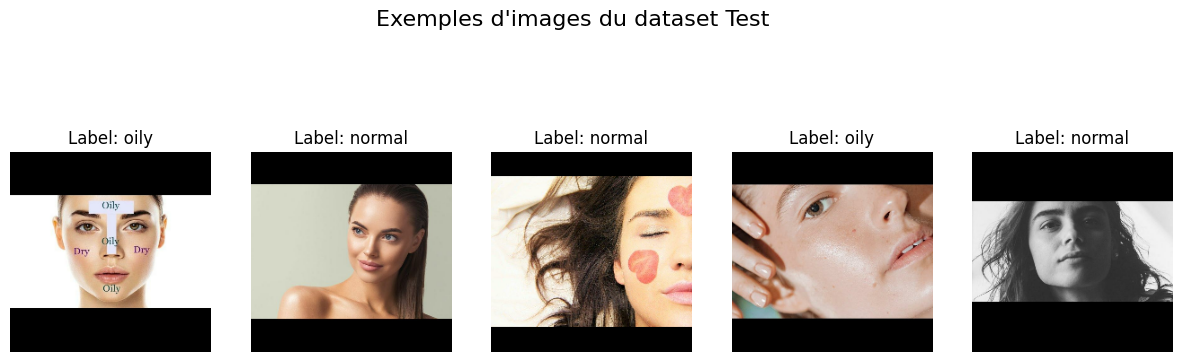

In [ ]:
# 📌 Afficher quelques images de chaque set
show_images(train_ds, "Exemples d'images du dataset Train")
show_images(valid_ds, "Exemples d'images du dataset Validation")
show_images(test_ds, "Exemples d'images du dataset Test")

In [ ]:
# 📌 Normalisation des images (les valeurs des pixels entre [0,1])
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
valid_ds = valid_ds.map(lambda x, y: (x / 255.0, y))
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

In [ ]:
# 📌 Création d'un générateur d'images avec augmentation (seulement pour le training)
train_datagen = ImageDataGenerator(
    rotation_range=40,  # Était 20 → On pousse plus loin
    width_shift_range=0.2,  # Était 0.1
    height_shift_range=0.2,  # Était 0.1
    shear_range=0.2,  # Était 0.1
    zoom_range=0.2,  # Était 0.1
    brightness_range=[0.7, 1.3],  # Ajout pour jouer sur la luminosité
    channel_shift_range=50.0,  # Ajout pour modifier les couleurs
    horizontal_flip=True,
    vertical_flip=False,  # ⚠️ Pas forcément utile ici
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator()  # Pas d'augmentation pour la validation
test_datagen = ImageDataGenerator()  # Pas d'augmentation pour le test

In [ ]:
# 📌 Création des générateurs
train_generator = train_datagen.flow_from_directory(
    dataset_path + "/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

valid_generator = valid_datagen.flow_from_directory(
    dataset_path + "/valid",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    dataset_path + "/test",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

Found 2756 images belonging to 3 classes.
Found 262 images belonging to 3 classes.
Found 134 images belonging to 3 classes.


In [ ]:
# 📌 Vérification du nombre d'images par catégorie
print(f"✅ Train : {train_generator.samples} images")
print(f"✅ Validation : {valid_generator.samples} images")
print(f"✅ Test : {test_generator.samples} images")

✅ Train : 2756 images
✅ Validation : 262 images
✅ Test : 134 images


In [ ]:
# 📌 Conversion des labels en one-hot encoding
y_train_onehot = to_categorical(train_generator.classes, num_classes=len(categories))
y_valid_onehot = to_categorical(valid_generator.classes, num_classes=len(categories))
y_test_onehot = to_categorical(test_generator.classes, num_classes=len(categories))

In [ ]:
print(f"✅ Train Labels One-Hot : {y_train_onehot.shape}")
print(f"✅ Validation Labels One-Hot : {y_valid_onehot.shape}")
print(f"✅ Test Labels One-Hot : {y_test_onehot.shape}")

✅ Train Labels One-Hot : (2756, 3)
✅ Validation Labels One-Hot : (262, 3)
✅ Test Labels One-Hot : (134, 3)


In [ ]:
# 📌 Nouveau modèle CNN avec régularisation
model = Sequential([
    # 📌 1ère couche convolutionnelle
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    # 📌 2ème couche convolutionnelle
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    # 📌 3ème couche convolutionnelle
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    # 📌 Remplace Flatten() par GlobalAveragePooling2D()
    GlobalAveragePooling2D(),

    # 📌 Couche fully connected avec régularisation L2
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),  # Ajout de L2
    Dropout(0.6),  # Augmentation du Dropout
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),

    # 📌 Couche de sortie avec 3 classes
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# 📌 Compilation du modèle
model.compile(
    optimizer=Adam(learning_rate=0.005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# 📌 Affichage du résumé du modèle
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 104,579 (408.51 KB)

 Trainable params: 104,131 (406.76 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# 📌 Entraînement du modèle avec les générateurs
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator
)

Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 48s 449ms/step - accuracy: 0.3990 - loss: 1.0814 - val_accuracy: 0.3550 - val_loss: 1.1044
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 43s 453ms/step - accuracy: 0.4139 - loss: 1.0743 - val_accuracy: 0.4198 - val_loss: 1.1049
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 44s 466ms/step - accuracy: 0.4171 - loss: 1.0708 - val_accuracy: 0.4237 - val_loss: 1.0912
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 43s 458ms/step - accuracy: 0.4116 - loss: 1.0738 - val_accuracy: 0.3397 - val_loss: 1.0932
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 83s 466ms/step - accuracy: 0.4351 - loss: 1.0685 - val_accuracy: 0.4046 - val_loss: 1.1025
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 82s 457ms/step - accuracy: 0.4217 - loss: 1.0773 - val_accuracy: 0.3931 - val_loss: 1.1048
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 43s 445ms/step - accuracy: 0.4257 - loss: 1.0738 - val_accuracy: 0.3435 - val_loss: 1.1024
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 43s 444ms/step - accuracy: 0.4097 - loss: 1.0754 - val_accu

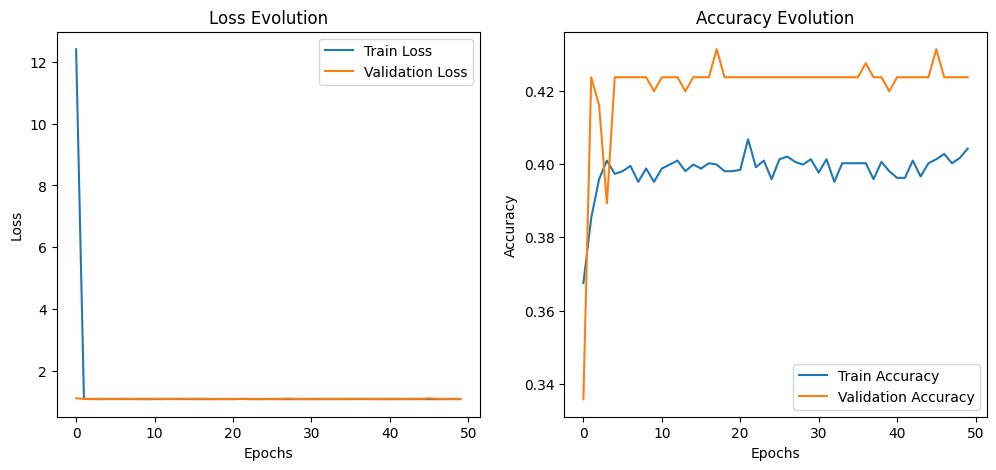

In [ ]:
# 📌 Fonction pour afficher les courbes de loss et d'accuracy
def plot_training_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].plot(history.history['loss'], label='Train Loss')
    axs[0].plot(history.history['val_loss'], label='Validation Loss')
    axs[0].set_title('Loss Evolution')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(history.history['accuracy'], label='Train Accuracy')
    axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[1].set_title('Accuracy Evolution')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.show()

# 📌 Affichage des résultats
plot_training_history(history)